# COMP47670 Assignment 1: Data Collection & Preparation


## Description

### Introduction
[Goodreads](https://www.goodreads.com/) is an American social cataloging website that allows individuals to search its database of books, annotations, quotes, and reviews. Users can sign up and register books to generate library catalogs and reading lists. They can also create their own groups of book suggestions, surveys, polls, blogs, and discussions. 
In this project, we will collect the data of books from Goodreads and try to find some interesting insights on **Books, Publishers, Authors** and into the **Relationship between Books and Cultures/Histories/Societies** 

### Plan
Due to Goodreads no longer issues new developer keys for our public developer API since December 8th 2020, find more information [here](https://help.goodreads.com/s/article/Does-Goodreads-support-the-use-of-APIs), we used web crawling to capture data from web pages instead of getting access from APIs. Our analysis is based on about 20k books collected.

The project is divided into 4 parts: 
1. Capture Raw Data and Parse Web Pages
2. Preprocess Parsed Data and Store Clean Data
3. Visualise and Analyse Data on Topics
4. Summarise and Plan for the Future Work

## Project

### Data Retrieval and Parsing

In [1]:
import argparse
import requests
import bs4 as bs
from urllib.parse import quote
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from glob import glob
from tqdm import tqdm
import json
import os.path
import traceback
import re

from termcolor import colored
from dotenv import load_dotenv
from functools import reduce
from geotext import GeoText

#### Web crawler

##### Introduction
Since the web-crawling will take too much time, I've attached the **parsed source pages** (in books_source_pages folder) and **json formatted raw data** (in shelves_pages folder) and commented the source code. The tree of the directory is as follows. The **Web Crawler** and **Shelves Merger** has been submitted to Github. Check the [Repo](https://github.com/ThunStorm/GoodReaders) if you are interested.
The script will read the list of the shelves of books to be downloaded, which, in our program, involves "fiction, fantasy, romance, comics, history, drama, classics, thriller, horror, kindle, novels, art, poetry, religion, business, crime, science, suspense, magic, adventure, historical-fiction, biography, non-fiction, mystery, science-fiction, dystopian, politics, favorites, to-read, to-buy, young-adult, paranormal, spanish, latin-american" and books labeled with "1700-2020(yr)"

##### Usage
Install the dependencies
`pip install -r requirements.txt`
Run web-crawler script (Preferable with additional arguments)
`python GoodReads-web-crawler.py`

##### Program

**Input:** shelves.txt

**Output:** source pages(books_source_pages), books data(shelves_pages), books url data(shelves_pages_books_urls)

books data(shelves_pages) in json format
One example of a book data follows:
```
{
    "books": [
            {
            "author": "Colleen Hoover",
            "book_format": "Kindle Edition",
            "date_published": "June 2016",
            "description": "This is an alternate cover edition for  ASIN B008TRUDAS.Following the unexpected death of her father, 18-year-old Layken is forced to be the rock for both her mother and younger brother. Outwardly, she appears resilient and tenacious, but inwardly, she's losing hope.Enter Will Cooper: The attractive, 21-year-old new neighbor with an intriguing passion for slam poetry and a unique sense of humor. Within days of their introduction, Will and Layken form an intense emotional connection, leaving Layken with a renewed sense of hope.Not long after an intense, heart-stopping first date, they are slammed to the core when a shocking revelation forces their new relationship to a sudden halt. Daily interactions become impossibly painful as they struggle to find a balance between the feelings that pull them together, and the secret that keeps them apart.",
            "genres": [
                "Romance",
                "New Adult",
                "Young Adult",
                "Contemporary",
                "Romance",
                "Contemporary Romance",
                "Fiction",
                "Womens Fiction",
                "Chick Lit",
                "Young Adult",
                "High School",
                "Realistic Fiction",
                "Poetry"
            ],
            "goodreads_url": "https://www.goodreads.com/book/show/30333938-slammed",
            "isbn": null,
            "language": "English",
            "pages": 354,
            "publisher": "Atria Books",
            "rating_average": 4.25,
            "rating_count": 216174,
            "settings": " Ypsilanti, Michigan  (United States)   ",
            "title": "Slammed"
        },
        ...
    ]
}

```

##### Directory

```
Dir:.
│  GoodReads-Data-Mining.ipynb
│  GoodReads-web-crawler-complement.py
│  GoodReads-web-crawler.py
│  README.md
│  requirements.txt
│  shelves.txt
│  shelves_merger.py
│      
├─books_source_pages (19,095 files / 7.55 GB)
│      .gitkeep
│      https%3A%2F%2Fwww.goodreads.com%2Fbook%2Fshow%2F1.Harry_Potter_and_the_Half_Blood_Prince
│      …
│      https%3A%2F%2Fwww.goodreads.com%2Fbook%2Fshow%2F9999.The_Box_Man
│      
├─shelves_pages (1,525 files / 454 MB)
│      .gitkeep
│      1700_1.json
│      1700_2.json
│      1700_3.json
│      …
│      young-adult_4.json
│      young-adult_5.json
│      
├─shelves_pages_books_urls(1,526 files / 2.95 MB)
│      .gitkeep
│      1700_1.json
│      1700_2.json
│      1700_3.json
│      …
│      young-adult_4.json
│      young-adult_5.json
│      
├─stats
│      .gitkeep
│      shelves_stats.json
│      
└─_data
        .gitkeep
        authors.json
        books.json
        genres.json
```
**Src:***
```
# Basic configuration of the scraper
load_dotenv()

BASE_URL = "https://www.goodreads.com"
# COOKIE = os.getenv("SESSION_ID")
COOKIE = "_session_id2=12df3dfcae3387f41db9ac57ecd5820e"
# PAGES_PER_SHELF = int(os.getenv("PAGES_PER_SHELF"))
PAGES_PER_SHELF = 5
JOBS = cpu_count()
PROCESSING_RATIO_THRESHOLD = 1.0

# Goodreads Scraper class
class GoodreadsScraper():
    def __init__(self, skip_processed_shelves, use_saved_books, use_saved_books_urls):
        self.skip_processed_shelves = skip_processed_shelves
        self.use_saved_books = use_saved_books
        self.use_saved_books_urls = use_saved_books_urls
        self.shelves = []
        self.shelves_stats = {}     
    
#     Define the shelves to be downloaded
    def load_shelves(self):
#         Load shelves list from a txt file
        with open("shelves.txt", "r", encoding='utf-8') as f:
            self.shelves = f.read().splitlines()
#         Load shelves of the years
        for year in range(1700, 2021):
            self.shelves.append(str(year))

#     Collect 5 pages data from each shelf
    def scrap_shelves(self):
        for i in range(1, PAGES_PER_SHELF + 1):
            for shelf in self.shelves:
                self.scrap_shelf(shelf, i)

#     Scrape one shelf
    def scrap_shelf(self, shelf, i):
        print(colored("Started - {} - page {}".format(shelf, i), 'yellow', attrs=['bold']))

#         Skip this shelf if already processed
        if self.skip_processed_shelves \
                and os.path.isfile("shelves_pages/{}_{}.json".format(shelf, i)) \
                and self.shelf_processing_ratio(shelf, i) >= PROCESSING_RATIO_THRESHOLD:
            print(colored("Finished - {} - page {} - already processed...".format(shelf, i), "magenta", attrs=['bold']))
            return -1

#         Get books urls (from disk or request)
        shelf_books_urls_path = "shelves_pages_books_urls/{}_{}.json".format(shelf, i)
        if self.use_saved_books_urls and os.path.isfile(shelf_books_urls_path):
            with open(shelf_books_urls_path, "r", encoding='utf-8') as f:
                books_urls = json.load(f)["books_urls"]
        else:
            shelf_url = BASE_URL + "/shelf/show/{}?page={}".format(shelf, i)
            headers = {"Cookie": COOKIE}
            try:
                source = requests.get(shelf_url, timeout=20, headers=headers)
            except Exception:
                return 0
#             Parse the web pages with BeautifulSoup
            soup = bs.BeautifulSoup(source.content, features="html.parser")
#             Capture URL for books
            books_urls = []
            for elem in soup.find_all(class_="bookTitle"):
                url = elem.get("href")
                books_urls.append(BASE_URL + url)
            with open(shelf_books_urls_path, "w", encoding='utf-8') as f:
                json.dump(
                    {"books_urls": books_urls},
                    f,
                    indent=4,
                    separators=(',', ': '),
                    ensure_ascii=False
                )

#         Scrape books from URLs obtained above
        books = Parallel(n_jobs=JOBS, verbose=10)(delayed(self.scrap_book)(book_url) for book_url in books_urls)
        books = list(filter(lambda x: x is not None, books))
        with open("shelves_pages/{}_{}.json".format(shelf, i), "w", encoding='utf-8') as f:
            json.dump(
                {"books": books},
                f,
                indent=4,
                separators=(',', ': '),
                sort_keys=True,
                ensure_ascii=False
            )

#         Save shelf's stats
        self.shelves_stats["{}_{}".format(shelf, i)] = {"scraped": len(books), "expected": len(books_urls)}
        self.save_stats()
        print(colored("Finished - {} - page {} with {}/{} books".format(shelf, i, len(books), len(books_urls)), 'green',
                      attrs=['bold']))
        return len(books)

#     Scrape one book from a shelf
    def scrap_book(self, book_url):
        try:
#             Get book's source page (from disk or request)
            book_source_page_path = "./books_source_pages/{}".format(quote(book_url, safe=""))
            if self.use_saved_books and os.path.isfile(book_source_page_path):
                soup_book = bs.BeautifulSoup(open(book_source_page_path), "html.parser")
            else:
                source_book = requests.get(book_url, timeout=20)
#                 Parse the book pages with BeautifulSoup
                soup_book = bs.BeautifulSoup(source_book.content, features="html.parser")
#                 Save the source data
                with open(book_source_page_path, "w", encoding='utf-8') as book_source_page:
                    book_source_page.write(str(soup_book))
            
#             Try to capture the needed data from parsed pages
            try:
                isbn = str(soup_book.find("meta", {"property": "books:isbn"}).get("content"))
            except:
                isbn = None
            if isbn == "null":
                isbn = None

            metacol = soup_book.find(id="metacol")

            title = metacol.find(id="bookTitle").text.strip()
            author = metacol.find(class_="authorName").text.strip()
            
            try:
                description = metacol.find(id="description").find_all("span")[-1].text.strip()
            except:
                description = None
            # try:
            #     img_url = soup_book.find(id="coverImage").get("src")
            # except:
            #     img_url = None
            try:
                rating_count = int(metacol.find("meta", {"itemprop": "ratingCount"}).get("content"))
            except:
                rating_count = None
            try:
                rating_average = float(metacol.find("span", {"itemprop": "ratingValue"}).text)
            except:
                rating_average = None
            try:
                pages = int(soup_book.find("meta", {"property": "books:page_count"}).get("content"))
            except:
                pages = None
            try:
                details = metacol.find(id="details")
            except:
                details = None
            try:
                book_format = details.find("span", {"itemprop": "bookFormat"}).text
            except:
                book_format = None
            try:
                language = details.find("div", {"itemprop": "inLanguage"}).text
            except:
                language = None

            try:
                buttons = details.find(class_="buttons")
                settings = buttons.find(id="bookDataBox").find_all(class_="infoBoxRowItem", recursive=False)[
                    0].getText().replace("\n", " ")
            except:
                settings = None

            try:
                publication = details.find_all(class_="row")[1].text.strip()
            except:
                publication = None
            try:
                date_published = str(publication.split("\n")[1].strip())
            except:
                date_published = None
            try:
                publisher = publication.split("\n")[2].strip()[3:]
            except:
                publisher = None

            try:
                genres = soup_book.find_all(class_="actionLinkLite bookPageGenreLink")
                genres = [genre.text for genre in genres]
            except:
                genres = []

            # try:
            #     reviews_divs = soup_book.find_all(class_="reviewText stacked")
            #     reviews = [review_div.find("span").find_all("span")[-1].text for review_div in reviews_divs]
            # except:
            #     reviews = []

            book = {
                "isbn": isbn,
                "title": title,
                "author": author,
                "settings": settings,
                "description": description,
                "publisher": publisher,
                "date_published": date_published,
                # "img_url": img_url,
                "rating_count": rating_count,
                "rating_average": rating_average,
                "book_format": book_format,
                "pages": pages,
                "language": language,
                "goodreads_url": book_url,
                "genres": genres
                # "reviews": reviews
            }
            return book

        except Exception as e:
            print("-" * 30)
            print(colored("ERROR: {}\n{}URL: {}".format(e, traceback.format_exc(), book_url), 'red'))
            return
        
#         Load the stats of the scraping to continue the process
    def load_stats(self):
        # with open("stats/shelves_stats.json", "r", encoding='utf-8') as f:
        with open("stats/shelves_stats.json", "r", encoding='utf-8') as f:
            self.shelves_stats = json.load(f)

#     Save the stats
    def save_stats(self):
        with open("stats/shelves_stats.json", "w", encoding='utf-8') as f:
            json.dump(
                self.shelves_stats,
                f,
                indent=4,
                separators=(',', ': '),
                sort_keys=True,
                ensure_ascii=False
            )
            
#     Ratio of web crawling process 
    def shelf_processing_ratio(self, shelf, i):
        shelf_stats = self.shelves_stats["{}_{}".format(shelf, i)]
        try:
            return shelf_stats["scraped"] / shelf_stats["expected"]
        except ZeroDivisionError:
            return 0

#     Check cookie before web crawling
    def check_cookie(self):
        print(colored("Checking session cookie...", 'yellow', attrs=['bold']))
        test_url = BASE_URL + "/shelf/show/mistery?page=2"
        headers = {"Cookie": COOKIE}
        source = requests.get(test_url, timeout=10, headers=headers)
        soup = bs.BeautifulSoup(source.content, features="html.parser")
        try:
            validation_clue = soup.body.findAll(text=re.compile('Showing 1'), limit=1)
            if len(validation_clue) > 0:
                raise
        except Exception:
            raise Exception('Must use a valid session cookie!')
        print(colored("Session cookie is OK!", 'green', attrs=['bold']))

#     Run the application
    def run(self):
        self.check_cookie()
        self.load_stats()
        self.load_shelves()
        self.scrap_shelves()
        self.save_stats()

# Command line argument
parser = argparse.ArgumentParser(description='Goodreads books scraper')
parser.add_argument('--skip_processed_shelves', action='store_true', help='Skip already processed shelves.')
parser.add_argument('--use_saved_books', action='store_true', help='Use saved books source files.')
parser.add_argument('--use_saved_books_urls', action='store_true', help='Use saved books urls.')
args = parser.parse_args()

# Run main Application
scraper = GoodreadsScraper(args.skip_processed_shelves, args.use_saved_books, args.use_saved_books_urls)
scraper.run()
```

### Parsed Data Preprocessing and Cleaning

One json file we obtained in Step 1 stores details of books in one page in one shelf. The goal of the below script is to clean, combine the parsed json data, and extract information from it.

In [7]:
SHELVES_PAGES_DIR = "./shelves_pages"

# Shelves merger class
class ShelvesMerger():
    def __init__(self, load_merged_books):
        self.load_merged_books = load_merged_books
        self.shelves_pages_paths = glob("{}/*.json".format(SHELVES_PAGES_DIR))
        self.books = []

#     Merge all jsons
    def merge_shelves_pages(self):
        print(colored("Merging {} shelves pages...".format(len(self.shelves_pages_paths)), 'yellow'))
        for shelf_page_path in tqdm(self.shelves_pages_paths):
            with open(shelf_page_path, "r", encoding="utf-8") as f:
                self.books += json.load(f)["books"]
        print(colored("Shelves merged to get a total of {} books".format(len(self.books)), 'green', attrs=["bold"]))
    
#     Remove duplicated books
    def remove_duplicated_books(self):
        print(colored("Removing duplicated books...", 'yellow'))
        unique_books = {book["goodreads_url"]: book for book in self.books}
        self.books = list(unique_books.values())
        print(colored("Duplicates removed to get a total of {} books".format(len(self.books)), 'green', attrs=["bold"]))

#     Remove invalid books without title author
    def remove_invalid_books(self):
        print(colored("Removing invalid books...", 'yellow'))
        self.books = [book for book in self.books if None not in [book["title"], book["author"]]]
        print(colored("{} valid books".format(len(self.books)), 'green', attrs=["bold"]))

#     Rectify settings using Geotext, the setting is expected to be a non-repetitive list of countries
    def rectify_settings(self):
        print(colored("Cleaning invalid settings...", 'yellow'))
        for book in self.books:
            if "//<![CDATA[" in book["settings"]:
                book["settings"] = None
            else:
                setting = GeoText(book["settings"])
                book["settings"] = list(set(setting.countries))
                
#     Nullify empty atrributes of the books
    def nullify_empty_attrs(self):
        print(colored("Nullifying empty attributes...", 'yellow'))
        for book in self.books:
            for attr in book:
                if type(book[attr]) is str and book[attr].strip() == "":
                    book[attr] = None

#     Optimise genres of the books
    def clean_genres(self):
        print(colored("Cleaning genres...", 'yellow'))
        for book in self.books:
            # Remove duplicates
            book["genres"] = list(set(book["genres"]))
            # Fix bad-written genres
            book["genres"] = [self.fix_genre(genre) for genre in book["genres"]]
    
#   Fix abbreviation  
    def fix_genre(self, genre):
        fixes = [
            ("Hi...", "History"),
            ("Lite...", "Literature"),
            ("International Rel...", "International Relations"),
            ("Science Fiction R...", "Science Fiction Romance"),
            ("Complementary Med...", "Complementary Medicine")
        ]
        for (old, new) in fixes:
            genre = genre.replace(old, new)
        return genre

#     Delete multple spaces in authors' name
    def clean_authors(self):
        print(colored("Cleaning authors names...", 'yellow'))
        for book in self.books:
            # Clean multiple spaces
            book["author"] = " ".join(book["author"].split())

#     Store a json of a list of  authors
    def dump_authors(self):
        print(colored("Dumping authors...", 'yellow'))
        authors = sorted(set(map(lambda b: b["author"], self.books)))
        print(colored("{} unique authors in total!".format(len(authors)), 'green', attrs=["bold"]))
        with open("_data/authors.json", "w", encoding='utf-8') as f:
            json.dump({"authors": authors}, f, indent=4, separators=(',', ': '), sort_keys=True, ensure_ascii=False)

#     Store a json of all  genres
    def dump_genres(self):
        print(colored("Dumping genres...", 'yellow'))
        genres = sorted(reduce(lambda r, c: r.union(c), map(lambda b: set(b["genres"]), self.books)))
        print(colored("{} unique genres in total!".format(len(genres)), 'green', attrs=["bold"]))
        with open("_data/genres.json", "w", encoding='utf-8') as f:
            json.dump({"genres": genres}, f, indent=4, separators=(',', ': '), sort_keys=True, ensure_ascii=False)

#     Deprecated
    # def dump_reviews(self):
    #     print(colored("Dumping reviews...", 'yellow'))
    #     reviews = {b["goodreads_url"]: b["reviews"] for b in self.books}
    #     with open("_data/reviews.json", "w", encoding='utf-8') as f:
    #         json.dump({"reviews": reviews}, f, indent=4, separators=(',', ': '), sort_keys=True, ensure_ascii=False)
    #     print(colored("Saved all books reviews!", 'green', attrs=["bold"]))

#     Store a json of all books
    def dump_books(self):
        print(colored("Dumping books...", 'yellow'))
        # for b in self.books:
        #     del b["reviews"]
        with open("_data/books.json", "w", encoding='utf-8') as f:
            json.dump({"books": self.books}, f, indent=4, separators=(',', ': '), sort_keys=True, ensure_ascii=False)
        print(colored("Saved all {} books!".format(len(self.books)), 'green', attrs=["bold"]))

#     Application process
    def run(self):
        self.merge_shelves_pages()
        self.remove_duplicated_books()
        self.remove_invalid_books()
        self.rectify_settings()
        self.nullify_empty_attrs()
        # self.clean_reviews()
        self.clean_genres()
        self.clean_authors()
        self.dump_authors()
        self.dump_genres()
        # self.dump_reviews()
        self.dump_books()

In [19]:
# parser = argparse.ArgumentParser(description='Goodreads books scraper')
# parser.add_argument('--load_merged_books', action='store_true', help='Skip merging and use saved books file.')
# args = parser.parse_args()
# shelves_merger = ShelvesMerger(args.load_merged_books)
# shelves_merger.run()

# In cmd ln uncomment above code and delete below one
shelves_merger = ShelvesMerger(False)
shelves_merger.run()

  7%|▋         | 110/1524 [00:00<00:01, 984.78it/s]

Merging 1524 shelves pages...


100%|██████████| 1524/1524 [00:39<00:00, 39.06it/s] 


Shelves merged to get a total of 33507 books
Removing duplicated books...
Duplicates removed to get a total of 19093 books
Removing invalid books...
19093 valid books
Cleaning invalid settings...
Nullifying empty attributes...
Cleaning genres...
Cleaning authors names...
Dumping authors...
9191 unique authors in total!
Dumping genres...
840 unique genres in total!
Dumping books...
Saved all 19093 books!


***We now have clean dataset in JSON foramat, including authors.json, books.json, genres.json in "_data" folder***


### Data Visualisation and Analysis on Several Topics
*As the JSON formatted file is good enough to store and present data of books, we shall not invert all data into csv format*

In [2]:
# Run 'pip install pyecharts' in Anaconda Prompt
from pyecharts import options as opts
from pyecharts.charts import Map
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

DATA_DIR = "./_data"

#### 1. Which country appears more often in settings of books
It is very hard to measure whether a country is great or have multiple explicit or implicit influence in the world. 
A setting (or backdrop) is the time and geographic location within a narrative, either nonfiction or fiction. It is a literary element. The setting initiates the main backdrop and mood for a story. The setting can be referred to as story world or milieu to include a context (especially society) beyond the immediate surroundings of the story. 
Therefore, a country is indirectly proved to be wildly-known, powerful, civilized, and positively impacts the world on the economy, culture, politics, etc, if it appears more often in settings in books.

In [3]:
settings = []
map_data = []

# Function of data visualisation on a map with pyecharts
def map_world() -> Map:
    c = (
        Map()
            .add("Numbers", map_data, maptype="world", zoom=1)
            .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
            .set_global_opts(
            title_opts=opts.TitleOpts(title="Popularity of Countries in Settings"),
            visualmap_opts=opts.VisualMapOpts(max_=500, is_piecewise=False),
        )
    )
    return c

# Read book data
with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    for book in books:
        if book["settings"] is not None:
            settings.extend(book["settings"])

# Count the numbers of countries in settings
pd_settings = pd.Series(settings).value_counts()
# pd_settings.index

# reformat to data format [[country, times],[country, times],...]
for i in range(0, len(pd_settings)):
    map_data.append([pd_settings.keys().tolist()[i], pd_settings.tolist()[i]])

d_map = map_world()
d_map.render_notebook()

#### Analysis 
1. Based on this research, the US has the highest level of impact on the world, The UK follows, then France, Italy, Germany, Canada, Japan, Ireland, Spain ...
2. Developing countries are less likely to be designed as a setting in a book than developed ones.
3. For authors, Countries in Asia, Africa,etc are less known.
4. Comparing to coastal countries, landlocked countries have less global influence. For landlocked countries in the developing world, the issue is particularly prevalent.

#### 2. During World Wars(1914-1919 and 1939-1946), what genres of books are published most?
> "Books are the most quiet and lasting friends, the easiest to reach, the wisest counselors and the most patient teachers."  -- Charles W. Eliot
---

Though reading might seem like simple fun, it can be helping your body and mind without you even realising what is happening. Reading can be more important for multiple reasons reasons, such as Cognitive **Exercises brain **, **Helps alleviate depression symptoms**, **Increases Desire towards achieving goals**, **Encourages positive thinking**. **Reduces stress**, etc. On the other hand, books are also tools for **propaganda** or to **reveal the truth**.  
In this part, we will discover what genres of books are published most during two special period: *World War I* and *World War II* and see whether the genres change in 3 years before and after wars.

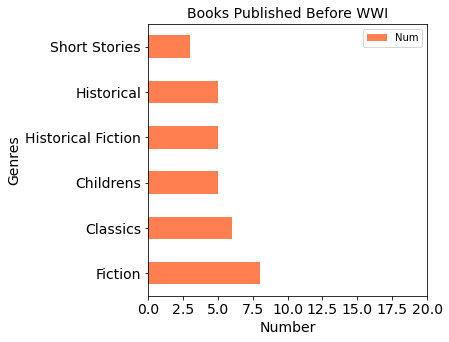

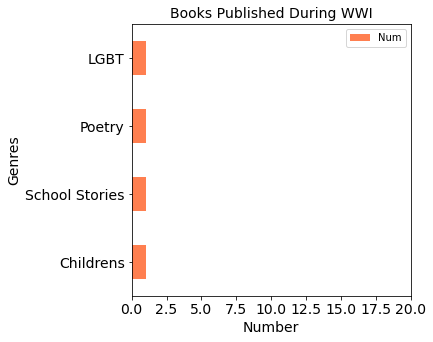

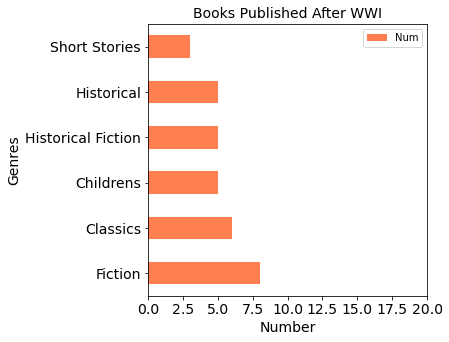

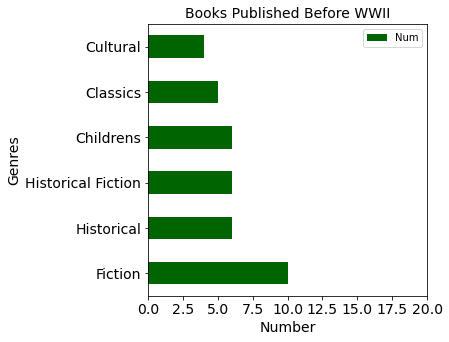

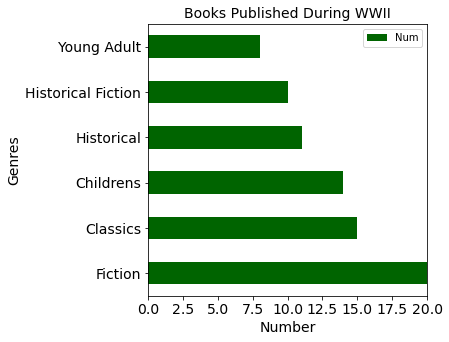

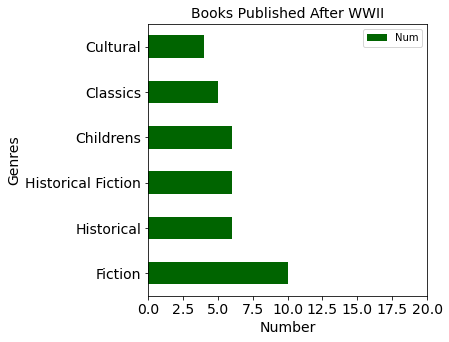

In [39]:
genres_bww1_3 = [] # 3 years before WWI
genres_ww1 = []    # During WWI
genres_ww2 = []
genres_bww2_3 = []
genres_ww1_3 = []   # 3 years after WWI
genres_ww2_3 = []

# Read data of books
with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    for book in books:
        if book["date_published"] is not None:
            if int(book["date_published"][-4:]) in range(1914,1920):
                genres_ww1.extend(book["genres"])
            elif int(book["date_published"][-4:]) in range(1939,1947):
                genres_ww2.extend(book["genres"])
            elif int(book["date_published"][-4:]) in range(1920,1923):
                genres_ww1_3.extend(book["genres"])
            elif int(book["date_published"][-4:]) in range(1947,1950):
                genres_ww2_3.extend(book["genres"])
            elif int(book["date_published"][-4:]) in range(1911,1914):
                genres_bww1_3.extend(book["genres"])
            elif int(book["date_published"][-4:]) in range(1936,1939):
                genres_bww2_3.extend(book["genres"])
# Invert data to pandas dataframe
pd_genres_ww1 = pd.Series(genres_ww1).value_counts().to_frame()
pd_genres_ww2 = pd.Series(genres_ww2).value_counts().to_frame()
pd_genres_ww1_3 = pd.Series(genres_ww1_3).value_counts().to_frame()
pd_genres_ww2_3 = pd.Series(genres_ww2_3).value_counts().to_frame()
pd_genres_bww1_3 = pd.Series(genres_ww1_3).value_counts().to_frame()
pd_genres_bww2_3 = pd.Series(genres_ww2_3).value_counts().to_frame()
# pd_genres_ww1.reset_index(inplace=True)

pd_genres_ww1.columns = ['Num']
pd_genres_ww2.columns = ['Num']
pd_genres_ww1_3.columns = ['Num']
pd_genres_ww2_3.columns = ['Num']
pd_genres_bww1_3.columns = ['Num']
pd_genres_bww2_3.columns = ['Num']

# Plotting
p10 = pd_genres_bww1_3[0:6].plot(kind="barh", figsize=(5, 5), fontsize=14, color="coral", width=0.5)
# customize the axes and title
p10.set_xlim((0,20))
p10.set_ylabel("Genres", fontsize=14)
p10.set_xlabel("Number", fontsize=14)
p10.set_title("Books Published Before WWI", fontsize=14);

p1 = pd_genres_ww1.plot(kind="barh", figsize=(5, 5), fontsize=14, color="coral", width=0.5)
# customize the axes and title
p1.set_xlim((0,20))
p1.set_ylabel("Genres", fontsize=14)
p1.set_xlabel("Number", fontsize=14)
p1.set_title("Books Published During WWI", fontsize=14);

p2 = pd_genres_ww1_3[0:6].plot(kind="barh", figsize=(5, 5), fontsize=14, color="coral", width=0.5)
# customize the axes and title
p2.set_xlim((0,20))
p2.set_ylabel("Genres", fontsize=14)
p2.set_xlabel("Number", fontsize=14)
p2.set_title("Books Published After WWI", fontsize=14);

p30 = pd_genres_bww2_3[0:6].plot(kind="barh", figsize=(5, 5), fontsize=14, color="darkgreen", width=0.5)
# customize the axes and title
p30.set_xlim((0,20))
p30.set_ylabel("Genres", fontsize=14)
p30.set_xlabel("Number", fontsize=14)
p30.set_title("Books Published Before WWII", fontsize=14);

p3 = pd_genres_ww2[0:6].plot(kind="barh", figsize=(5, 5), fontsize=14, color="darkgreen", width=0.5)
# customize the axes and title
p3.set_xlim((0,20))
p3.set_ylabel("Genres", fontsize=14)
p3.set_xlabel("Number", fontsize=14)
p3.set_title("Books Published During WWII", fontsize=14);

p4 = pd_genres_ww2_3[0:6].plot(kind="barh", figsize=(5, 5), fontsize=14, color="darkgreen", width=0.5)
# customize the axes and title
p4.set_xlim((0,20))
p4.set_ylabel("Genres", fontsize=14)
p4.set_xlabel("Number", fontsize=14)
p4.set_title("Books Published After WWII", fontsize=14);
              

#### Analysis 
1. During World War I, the business of publishers was hard hit by wars
2. During World War I, people (authors and readers) focused more on the nature of human (LGBT, Love, family, etc) 
3. During World War II, publishers were not seriously affected than in WWI
4. From beginning to the mid of 20th century, people always liked reading fiction, historical, historical fiction, children and classics books. 

#### 3.  Does the number of publications increase year by year?

,Num
1783,1
1789,1
1790,1
1794,1
1797,1
...,...
2016,375
2017,384
2018,375
2019,367


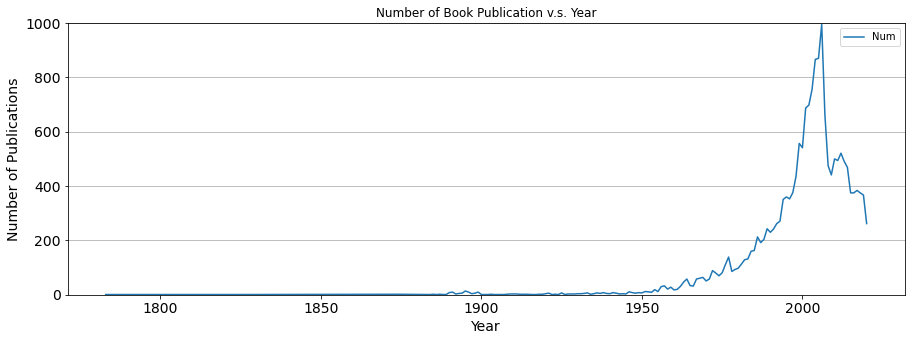

In [90]:
yr = []

with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    for book in books:
        if book["date_published"] is not None:
            if (int(book["date_published"][-4:]) >= 1700 and (int(book["date_published"][-4:]))<= 2020):
                yr.append(int(book["date_published"][-4:]))
pd_yr = pd.Series(yr).value_counts().to_frame()
pd_yr.columns = ['Num'] 
# Sort df by index
pd_yr.sort_index(inplace=True)
p = pd_yr.plot(title="Number of Book Publication v.s. Year", figsize=(15,5), fontsize=14)
plt.ylim(0,1000)
plt.grid(axis="y")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Publications', fontsize=14)
pd_yr

#### Analysis 
1. Overall, the number of published books keep rising with fluctuation, reach the peak in 2006(995), and decline after this year.
2. Probably because of the Amazon’s release of the Kindle in 2007, the paper published books dramatic sharply that year. [News](https://www.bbc.com/future/article/20160124-are-paper-books-really-disappearing) 

#### 4.  Is there any relationship between rating and year published (in recent 10 decades)?

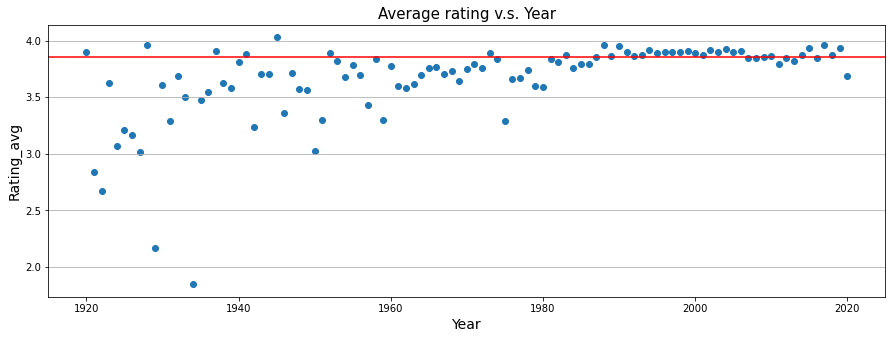

In [125]:
rt = {}          # try using dict to solve this part
rt_num = {}
rt_sum = 0.0
rt_sum_num = 0.0

# Initialization
for i in range(1920, 2021):
    rt[i] = 0
    rt_num[i] = 0

with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    for book in books:
        if book["date_published"] is not None and (int(book["date_published"][-4:]) >= 1920 and (int(book["date_published"][-4:]))<= 2020):
            rt[int(book["date_published"][-4:])] += float(book["rating_average"])
            rt_num[int(book["date_published"][-4:])] += 1
            rt_sum += book["rating_average"]
            rt_sum_num += 1

for i in range(1920, 2021):
    try:
        rt[i] = float(rt[i] / rt_num[i])
    except ZeroDivisionError:
        pass
    
year = list(rt.keys())
rating = list(rt.values())

# # create a new figure, setting the dimensions of the plot
plt.figure(figsize=(15,5))
# set up the plot
plt.scatter(year, rating);
plt.axhline(float(rt_sum/rt_sum_num), color='r')
plt.title('Average rating v.s. Year', fontsize=15)
plt.grid(axis="y")
plt.xlabel('Year', fontsize=14)
plt.ylabel('Rating_avg', fontsize=14)
plt.show()

#### Analysis 
The average rating of books published after 1980 are closed to overall average rating.


#### 5.  Publishers Comparison - Who published the most and who published the highest rated

In [210]:
pub_li = [] # store names of publishers
pub_di = {} # dictionary store publishers:number of books
pub_di_rt = {}# store publishers:rating of books
pub_di_num = {}# store non-zero-rated books

with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    
    for book in books:
        if book["publisher"] is not None:
            pub_li.append(book["publisher"])
    pub_st = set(pub_li)
    pub_li = list(pub_st)
    
    for pub in pub_li:
        pub_di[pub] = 0
        pub_di_rt[pub] = 0.0
        pub_di_num[pub] = 0.0
    
    for book in books:
        if book["publisher"] is not None:
            pub_di[book["publisher"]] += 1
            if book["rating_average"] != 0:
                pub_di_rt[book["publisher"]] += book["rating_average"]
                pub_di_num[book["publisher"]] += 1.0

for pub in pub_li:
    try:
        pub_di_rt[pub] =  pub_di_rt[pub] / pub_di_num[pub]
    except ZeroDivisionError:
        pass

# Transforms dictionary to dataframe
df = pd.DataFrame.from_dict(pub_di, orient = 'index', columns = ["Num"])
df_rt = pd.DataFrame.from_dict(pub_di_rt, orient = 'index', columns = ["Rating"])

# resets index
df.reset_index(inplace=True)
df_rt.reset_index(inplace=True)

# merges two dataframes
df_pub = pd.merge(df, df_rt, on='index' )

# sorts and spots on the rating of the top 15 publishers
df_pub_new = df_pub.sort_values(by=["Num"], axis=0, ascending=False)     
df_pub_new[:15]

,index,Num,Rating
2639,Vintage,418,3.907536
3586,Penguin Classics,362,3.872707
915,Penguin Books,295,3.898949
2592,Ballantine Books,211,3.931327
446,Pocket Books,163,3.932716
3057,HarperCollins,163,3.952761
2085,Bantam,148,3.945811
2182,Berkley,139,3.929712
878,Oxford University Press,131,3.823692
212,Random House,125,3.956880


#### Analysis 
Though Vintage published the most of books (418) but its average rating is not the best one. W. W. Norton Company published the highest rated books in top 15 publishers 

#### 6. Books recommendation (except Harry Potter series)

In [144]:
# Recommend 20 Books + Harry Potter series
#  Critiria: 1. Average rating greater than 4.25, 2. Number of readers more than 1,000,000
n = 1
with open("{}/books.json".format(DATA_DIR), "r", encoding='utf-8') as f:
    books = json.load(f)["books"]
    for book in books:
        if book["rating_average"] is not None and book["rating_average"]>= 4.25 and book["rating_count"] >= 1000000 and "Harry Potter" not in book["title"]:
            print(str(n) + '. ' + book["title"] + ' / ' + str(book["rating_average"]) + ' / ' + str(book["rating_count"]))
            n += 1

1. To Kill a Mockingbird / 4.28 / 4723562
2. Pride and Prejudice / 4.27 / 3164139
3. The Little Prince / 4.31 / 1469452
4. The Hobbit, or There and Back Again / 4.28 / 3029253
5. Gone with the Wind / 4.3 / 1099796
6. The Fellowship of the Ring / 4.37 / 2432216
7. Night / 4.34 / 1011210
8. Ender's Game / 4.3 / 1173722
9. The Book Thief / 4.38 / 1930023
10. The Help / 4.46 / 2256196
11. Where the Crawdads Sing / 4.47 / 1189071
12. The Kite Runner / 4.31 / 2526429
13. Where the Sidewalk Ends / 4.3 / 1214893
14. A Game of Thrones / 4.44 / 2076298
15. The Hunger Games / 4.32 / 6651602
16. A Thousand Splendid Suns / 4.38 / 1202016
17. Catching Fire / 4.29 / 2645438
18. The Lightning Thief / 4.26 / 2109623
19. Me Before You / 4.26 / 1221185
20. All the Light We Cannot See / 4.33 / 1104203


### Summary and future work

There are lots of great books haven't been filed into Goodreads due to multiple reasons, for instance, translations issues and cultural diversity. So, it makes sense to combine more data from different source. For the code, the efficiency of web crawler can still be improved (it took too long to capture data like about 2 days to scrape 20k books.) Also the books, especially published in 18-20 century, will be collected more in future work.

Based on the current limited data, we have insights in "Analysis" parts above. 

> “Many people, myself among them, feel better at the mere sight of a book.”
– Jane Smiley, Thirteen Ways of Looking at a Novel